## Instructions {-}

1. This is the template you may use to submit your code and report for the prediction problems on Kaggle.

2. You may modify the template if you deem fit, but it should have the information asked below.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from catboost import CatBoostRegressor
import xgboost as xgb

## A.1) Data cleaning

Mention the data cleaning steps taken to prepare your data for developing the model. This may include imputing missing values, dealing with outliers, combining levels of categorical variable(s), etc.

While examining our data, we noticed that our y log values were right skewed and close together. As such, we applied a log transformation to the data. After this, we performed feature selection, as described in A3. As a final step, we imputed our train and test data using a KNN algorithm.

In [3]:
np.random.seed(0)
train = pd.read_csv('train.csv')
test =pd.read_csv('test.csv')

X = train.drop(columns = ['y','id'])
y = train['y']

test_ids = test['id']
test.drop(columns = 'id',inplace = True)

X = X.astype(float)
y = y.astype(float)
test = test.astype(float)

y = np.log(y)

# FEATURE SELECTION

# dropping columns that have only one kind of value in them
counts = pd.DataFrame(X.nunique()).reset_index()
todrop = counts[counts[0] == 1]['index']

X.drop(columns = todrop,inplace = True)
test.drop(columns = todrop, inplace = True)


# Dropping highly correlated variables to avoid multicollinearity
cols = X.columns

corrs = pd.DataFrame(np.triu(X.corr()))
corrs.columns = cols

bad_cols = []

# Dropping highly correlated columns
for i in range(corrs.shape[1]):
    for j in range(corrs.shape[0]):
        if (corrs.iloc[j,i] > 0.95):
            if (i != j):
                bad_cols.append(i)

to_drop_for_corr = list(np.unique(np.array(bad_cols)))
X.drop(X.columns[to_drop_for_corr],axis = 1, inplace = True)
test.drop(test.columns[to_drop_for_corr],axis = 1, inplace = True)


# IMPUTATION
Xknn = KNNImputer(n_neighbors=7)
Xknn.fit(X)
X = pd.DataFrame(Xknn.transform(X))
test = pd.DataFrame(Xknn.transform(test))


## A.2) Exploratory data analysis

Mention any major insights you obtained from the data, which you used to develop the model. PLease put your code or visualizations here if needed.

While exploring the data, we came across a few observations that we incorporated into our model building process:
- y should have the log variable taken. The data was massively skewed (as shown below) 
- Some of the variables appear to be categorical, and a few of the columns are not unique.
- Some of the columns only have one value (e.g. x063 and x137).
- There are a lot of instances of strong multicollinearity. As such, we had to take this into account when doing our data cleaning by removing many of those columns, and overall reducing the number of predictors to improve the model building process.
- A lot of the variables were heavily right skewed, but there wasn't much of a difference when we tried to account for this (e.g. taking the log of some variables), but because this didn't have a huge impact, we decided that this change was not necessarily needed.


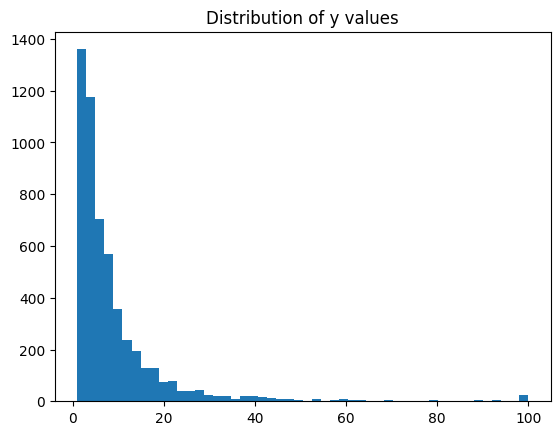

In [9]:
plt.hist(train['y'], bins=50)
plt.title("Distribution of y values")
plt.show()

## A.3) Feature selection/reduction

Mention the steps for feature selection/reduction. PLease put your code or visualizations here if needed.

For feature selection, we settled on creating a correlation table and removing all variables that were over 95% correlated with another. Furthermore, we also removed the columns filled with one value that were mentioned in A.2, as these did not contribute to the y variable.

At this point, since there were NA values, we decided to fill them in with imputation. Initially, we did this with MICE, but we eventually settled on using KNN imputation because [we found a paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4228077/) comparing the two methods and determined that KNN would perform better specifically for our data.

The code detailing our steps for feature selection used in our final model is included in question A1 of this notebook. 

## A.4) Developing the model

Mention the logical sequence of steps taken to obtain the final model. 

We had many struggles when it comes to finding a perfect model, which was discussed in the answer to Question 5. For our final model, however, we decided to make a model using Catboost and combined catboost with another model to decrease our RMSE further, as the RMSE for a single catboost was not accurate enough. We opted for XGBoost and used a weighted average of 80% catboost and 20% XGBoost as a starter percentage. This ultimately worked once we added an intercept value.

To see if our model's predictions needed some kind of offset value or intercept, we decided to develop a model and plot our fitted model's predictions on the training data against the y values. From here, we observed that there was a slight offset between our y values and the predictions, which was around 2.5 (please see plots below for a comparison). As such, we added as an intercept to our predictions, which fit the y values better. For our Kaggle submission, we then added 2.5 to all of our predictions on the test data before submitting, which decreased our RMSE to around 8.68 on the public leaderboard and finally  provided us with a suitable model. 

Below is the code for the fitted model, as well as the visualization of our predictions with the offset plotted against the y values.

In [ ]:
catmodel = CatBoostRegressor(random_state=0).fit(X,y)
xgbmodel = xgb.XGBRegressor(random_state=0).fit(X,y)

cat_preds = catmodel.predict(test) 
xgb_preds = xgbmodel.predict(test)

# Transforming values back to not log form
cat_pred_y = np.exp(catmodel.predict(test))
xgb_pred_y = np.exp(xgbmodel.predict(test))
test_preds = 0.8*cat_pred_y + 0.2*xgb_pred_y

test_preds += 2.5

predictions = pd.DataFrame({'id':test_ids,'y':test_preds})

predictions.to_csv('catxgbintercept.csv',index=False) # RMSE is 8.68

In [19]:
# SEE BELOW FOR PLOTS WITHOUT AND WITHOUT INTERCEPT ON TRAINING DATA

cat_pred_y = np.exp(catmodel.predict(X))#
xgb_pred_y = np.exp(xgbmodel.predict(X))
test_pred_x = 0.8*cat_pred_y + 0.2*xgb_pred_y
test_pred_x

array([ 5.08375058,  1.53237226,  7.34604489, ..., 11.00704553,
       12.33411225, 25.5360077 ])

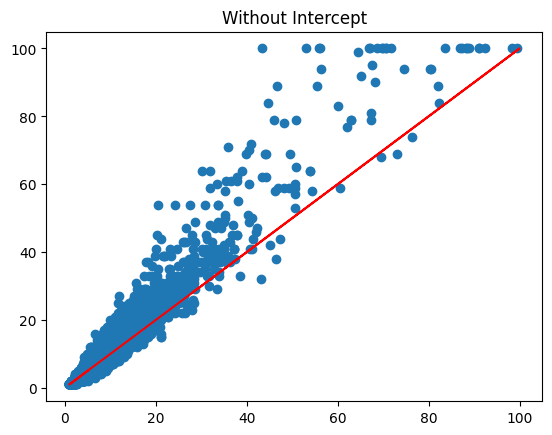

In [21]:
plt.scatter(test_pred_x, np.exp(y))
plt.plot(np.exp(y), np.exp(y), c='red')
plt.title("Without Intercept")
plt.show()

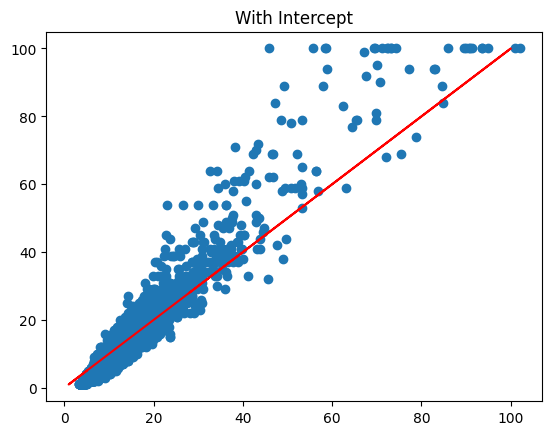

In [23]:
plt.scatter(test_pred_x+2.5, np.exp(y))
plt.plot(np.exp(y), np.exp(y), c='red')
plt.title("With Intercept")
plt.show()

## A.5) Discussion

Please provide details of the models/approaches you attempted but encountered challenges or unfavorable outcomes. If feasible, kindly explain the reasons behind their ineffectiveness or lack of success. Additionally, highlight the significant challenges or issues you encountered during the process.

We tried many different approaches before coming to our final model. For a lot of these, we attempted to use a train test split, as we wanted to validate the accuracy of our models  before submitting. However, due to a large discrepancy we experienced between our training accuracies and the accuracies we received on Kaggle, we instead decided to use the entire training dataset for training purposes only.

For feature selection, a couple of methods were utilized during the model building process and selected based on which achieved the best results.
First, we tried using PCA with variances ranging between 95% and 99%, however, ultimately we hit a wall with the success of our models built using this method.

We then moved on to VIF and removed any features with a VIF score of over 3 to remove multicollinearity, but this ended up being too restrictive and removed too much information. Furthermore, this would have required an iterative process that would be very computationally expensive.

For just about every model, we used a GridSearch to find the best parameters. Our approaches included an initial, coarser Grid Search on each of the models to help us narrow down the optimal parameters, after which we refined our models further with a finer grid search and parameters within a smaller range. This included searches for Random Forest, XGBoost, MARS, Linear Regression, SVR, and Stacking Regressors. We made a series of Neural Networks as well to see if we could further lower the RMSE. The neural networks in particular had lower values for RMSEs, but did poorly on Kaggle. We suspect it was due to overfitting, due to the larger number of parameters. As such, we changed our approach.

One of the most notable changes to our approach was how we cleaned our data, which included not using PCA as well as removing multicollinear predictors. From there, many of our models proved to be more accurate. This showed us first-hand of what a garbage in, garbage out situation might look like. Since the data had previously been preprocessed differently, with not as many dimensions being reduced, it was hard to tune our model with these changes and became easier after we took a different approach.

## A.6) Conclusion

* Do you feel that you gain valuable experience, skills, and/or knowledge? If yes, please explain what they were. If no, please explain.
* What are things you liked/disliked about the project and/or work on the project?

It was good practice for applying all the skills we have been learning in our data science classes for the last 2 years. Furthermore, we learned a lot about which techniques to use a different times. For example, while our initial instinct was to use PCA, we discovered that PCA may not necessarily help us with data preprocessing and can actually negatively impact our model's accuracies if not used at the right time. Furthermore, this process showed us the importance of pre-processing, as mentioned in Question 5. This was also a good example of how the most advanced models may not necessarily best fit the data, and that it really depends on what the data actually looks like.

The process was certainly frustrating when we had better training results and poorer Kaggle results, as we had trouble figuring out what was wrong with our model building process. However, we got a lot of experience looking at every part of the model building process when things were not going well, as opposed to just focusing on the model itself. 

## Please make sure your github repo has all the code and  ensure that your code is capable of reproducing the outcomes you have submitted. It is important to avoid any form of academic misconduct or cheating by using your peer's submission file